In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import re
from scipy.stats import wilcoxon

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_part0 = pd.read_csv('WAG_C_M.csv',';',header=0)
data_part0.tail()

,month,WAG_C_M
279,01.04.2016,36497.0
280,01.05.2016,37270.0
281,01.06.2016,38447.0
282,01.07.2016,35888.0
283,01.08.2016,34095.0


Данные заканчиваются на августе 2016. Недостающую часть можно использовать для уточнения модели или сравнения прогнозов.

In [3]:
#используем данные поновее, взятые не из оффициальных источников
data_part1 = pd.read_html('http://rusfact.ru/node/79578',header=[0,1],decimal=',')[0].replace(regex=',',value='.')
data_part1.tail()

Среднемесячная номинальная начисленная  заработная плата одного работника  \
                                                                          ГОД   
103                                        2020 (июль)                          
104                                      2020 (август)                          
105                                     2020(сентябрь)                          
106                                     2020 (октябрь)                          
107                                      2020 (ноябрь)                          

                                                                                     \
    Офиц. средне-годовой курс (или курс на последний день периода) рубля к $ и Евро   
103                                       73.36/ 86.25                                
104                                       74.64/ 88.74                                
105                                       79.68/ 93.02                                
106                                       79.33 /92.63                                
107                                       75.86 /90.46                                

                                                                            \
    средняя зарплата в рублях средняя зарплата в $ средняя зарплата в Евро   
103                   50145 р                684 $                   581 €   
104                   47649 р                638 $                   537 €   
105                   49259 р                618 $                   530 €   
106                   49539 р                624 $                   534 €   
107                   49274 р                649 $                   545 €   

                        
    Unnamed: 5_level_1  
103                NaN  
104                NaN  
105                NaN  
106                NaN  
107                NaN

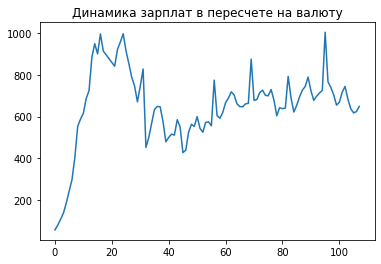

In [4]:
plt.plot(data_part1.iloc[:,3].dropna().apply(lambda x: re.sub('[\s\$]','',x)).astype('float'))
plt.title('Динамика зарплат в пересчете на валюту')
plt.show()

In [5]:
ind = data_part1[data_part1.iloc[:,0]=='2016 (июль)'].index[0]
data_part1 = pd.DataFrame([pd.date_range(start='07.01.2016',end='07.01.2020',freq='MS'),
                           data_part1[~data_part1.iloc[:,0].str.contains('сред')].iloc[ind:,2].apply(lambda x: int(re.sub('[\sр]','',x))).values]).T
data_part1.columns=data_part0.columns
data_part1.WAG_C_M=data_part1.WAG_C_M.astype('float')
data_part1.index+=data_part0.shape[0]

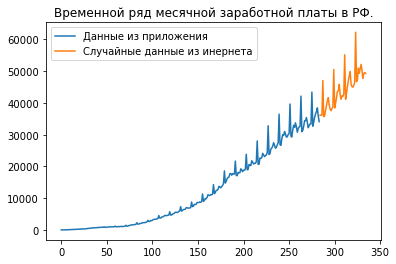

In [6]:
plt.plot(data_part0.WAG_C_M,label='Данные из приложения')
plt.plot(data_part1.WAG_C_M,label='Случайные данные из инернета')
plt.title('Временной ряд месячной заработной платы в РФ.')
plt.legend()
plt.show()

Абсолютной сшивки данных не произошло, они друг другу противоречат (пускай и несильно)

Для универсальности и удобства проверки будем прогнозировать по общим данным, а добавленные данные будут играть роль отложенной выборки

In [7]:
data = pd.DataFrame(data_part0.values[:,1].astype('float'),columns=['wages'])

Естественным преобразованием для зарплат/цен является логарифмирование, из-за относительного, а не абсолютного, характера инфляции.

<AxesSubplot:>

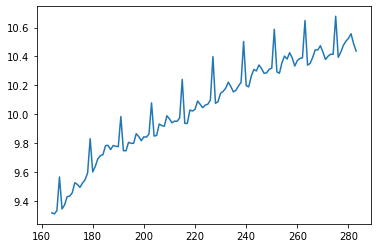

In [8]:
data['log_wages']=np.log(data.wages)

data.log_wages[-120:].plot()

In [9]:
pr_aDF = lambda x: print(f'Augmented Dickey-Fuller test p-value for column {x.name}: p={adfuller(x)[1]}')
pr_aDF(data.wages)
pr_aDF(data.log_wages)
#Недостаточно для стационарности

Augmented Dickey-Fuller test p-value for column wages: p=0.9918495954854735
Augmented Dickey-Fuller test p-value for column log_wages: p=0.03401037411699027


Augmented Dickey-Fuller test p-value for column log_s_diff: p=0.5958329174984899


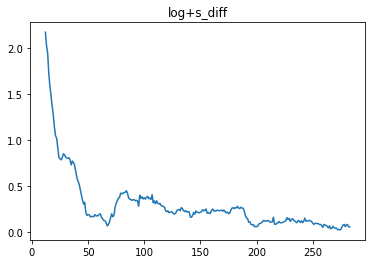

In [10]:
data['log_s_diff']=data.log_wages.diff(12)
pr_aDF(data.log_s_diff.dropna()[-150:])
data.log_s_diff.plot(title='log+s_diff')
plt.show()

Augmented Dickey-Fuller test p-value for column log_s_1_diff: p=3.0130453852845656e-26


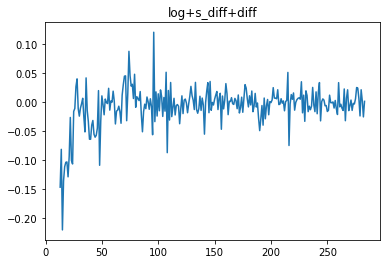

In [11]:
data['log_s_1_diff']=data.log_s_diff.diff()
pr_aDF(data.log_s_1_diff.dropna()[-150:])

data.log_s_1_diff.plot(title='log+s_diff+diff')
plt.show()

Получено преобразование, которое отвечает условию стационарности на уровне значимости 0.05

In [12]:
y = data.log_s_1_diff.dropna()[-150:]

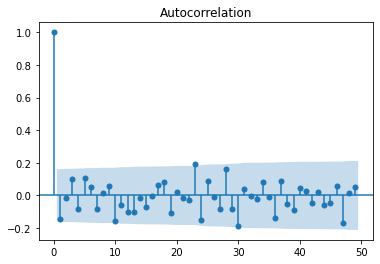

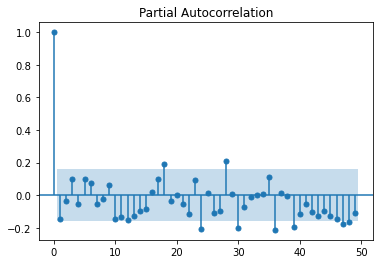

In [13]:
plot_acf(y,lags=49)
plot_pacf(y,lags=49)
plt.show()

In [14]:
d,D=1,1
q=[10,23,30]
Q=[1,2,3]
p=[11,13,18,28,30]
P=[1,2,3]

Обучение модели будем производить по последней части данных, которая будет отображать тренд последних лет, не беря в расчет все многообразие экономической ситуации с нулевых. Например, в данных будет кризис 2014-15


In [15]:
y = data.log_wages[-60:]
model = ARIMA(y,order=(p,d,q),seasonal_order=(P,D,Q,12),trend='ct')

fitted = model.fit()

In [16]:
def plot_forecast(model,T=24):
    #T defines forecasting period
    d = np.exp(y)
    plt.plot(d,label='Historical data')
    plt.plot(np.exp(model.forecast(T)),label='Forecasted data')
    plt.plot(data_part1.WAG_C_M[:T],label='Actual data')
    plt.legend()
    plt.ylabel('Р')
    plt.title('Wages timeseries')
    plt.show()
    diff =(y-model.predict())[-30:]
    plt.title('Residual difference')
    plt.plot(diff,label='wilcoxon: %4f' % wilcoxon(diff)[1])
    plt.legend()
    plt.show()
    plot_acf(diff,lags=diff.size//2-1)
    plt.show()
    plot_pacf(diff,lags=diff.size//2-1)
    plt.show()

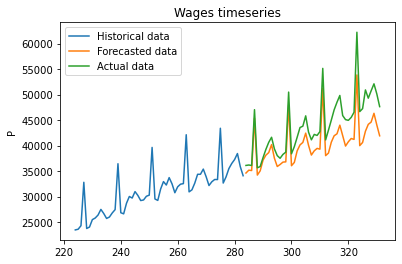

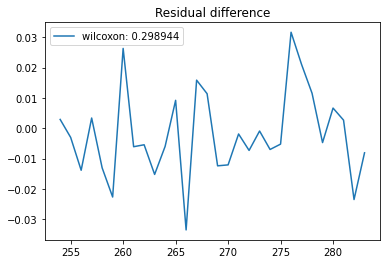

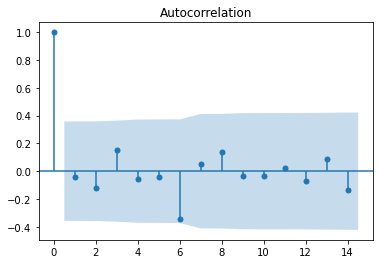

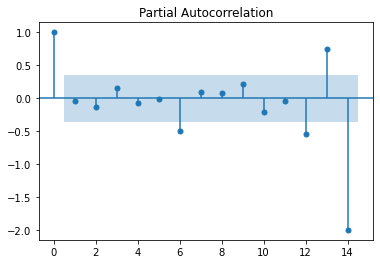

In [17]:
plot_forecast(fitted,48)

In [18]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                   SARIMAX Results                                                    
======================================================================================================================
Dep. Variable:                                                      log_wages   No. Observations:                   60
Model:             ARIMA([11, 13, 18, 28, 30], 1, [10, 23, 30])x(3, 1, 3, 12)   Log Likelihood                 130.068
Date:                                                        Wed, 24 Feb 2021   AIC                           -226.136
Time:                                                                22:57:01   BIC                           -194.684
Sample:                                                                     0   HQIC                          -214.300
                                                                         - 60                                         
Covariance Type:                                                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.543e-09      0.001    8.2e-06      1.000      -0.001       0.001
x1         -8.318e-10      0.001  -1.23e-06      1.000      -0.001       0.001
ar.L11        -0.0927      0.477     -0.194      0.846      -1.028       0.843
ar.L13         0.1028      0.390      0.263      0.792      -0.662       0.868
ar.L18         0.0270      0.510      0.053      0.958      -0.973       1.027
ar.L28         0.2771      0.431      0.643      0.520      -0.568       1.122
ar.L30         0.0807      2.408      0.034      0.973      -4.638       4.800
ma.L10        -0.1002      0.369     -0.272      0.786      -0.824       0.623
ma.L23         0.1922      0.340      0.566      0.571      -0.473       0.858
ma.L30        -0.0084      2.650     -0.003      0.997      -5.202       5.185
ar.S.L12      -0.1061      3.766     -0.028      0.978      -7.488       7.276
ar.S.L24      -0.1106      6.803     -0.016      0.987     -13.445      13.224
ar.S.L36      -0.1650     10.258     -0.016      0.987     -20.270      19.940
ma.S.L12      -0.0187      4.107     -0.005      0.996      -8.069       8.031
ma.S.L24      -0.0936      7.155     -0.013      0.990     -14.117      13.930
ma.S.L36      -0.1601     11.824     -0.014      0.989     -23.336      23.015
sigma2         0.0002      0.000      1.572      0.116   -4.78e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.46   Prob(JB):                         0.71
Heteroskedasticity (H):               0.77   Skew:                             0.29
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+20. Standard errors may be unstable.
"""

In [19]:
fitted.specification

{'seasonal_periods': 12,
 'measurement_error': False,
 'time_varying_regression': False,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'order': ([11, 13, 18, 28, 30], 1, [10, 23, 30]),
 'seasonal_order': (3, 1, 3, 12),
 'k_diff': 1,
 'k_seasonal_diff': 1,
 'k_ar': 30,
 'k_ma': 30,
 'k_seasonal_ar': 36,
 'k_seasonal_ma': 36,
 'k_ar_params': 5,
 'k_ma_params': 3,
 'trend': 'ct',
 'k_trend': 2,
 'k_exog': 0,
 'mle_regression': True,
 'state_regression': False}

Итоговая модель SARIMAX(39,1,30)x(3,1,3,12) демонстрирует неплохую предсказательную силу. Критерий Льюнга-Бокса и графики демонстрируют отсутствие остаточной автокорреляции.

Тем не менее, выбранная модель содержит в себе огромное число параметров - самый жадный вариант из представленного набора. Ничуть не удивительно, что зависимость удалось восстановить.

Возьмем что-нибудь попроще

In [20]:
def suggest_params(y,nlags=14,ft=0.1):
    p_acf = np.where(acf(y,nlags=nlags)>ft)[0]
    p_pacf = np.where(pacf(y,nlags=nlags)>ft)[0]
    d = {}
    d['q']=p_acf[p_acf % 12 != 0 ]
    d['Q']=p_acf[p_acf % 12 == 0 ]//12
    d['p']=p_pacf[p_pacf % 12 != 0 ]
    d['P']=p_pacf[p_pacf % 12 == 0 ]//12
    return d
suggest_params(y)

{'q': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14]),
 'Q': array([0, 1]),
 'p': array([1, 2, 3, 4, 5, 6]),
 'P': array([0, 1])}

In [21]:
P=1;Q=1
p=6
q=11

In [22]:
f2 = ARIMA(y,order=(p,d,q),seasonal_order=(P,D,Q,12),trend='ct').fit()

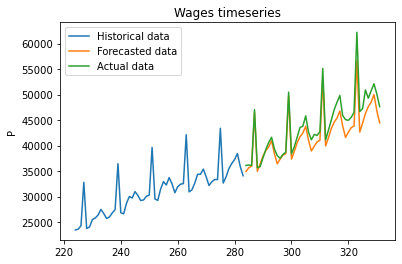

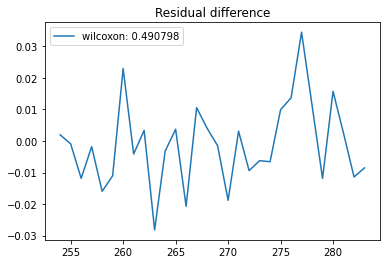

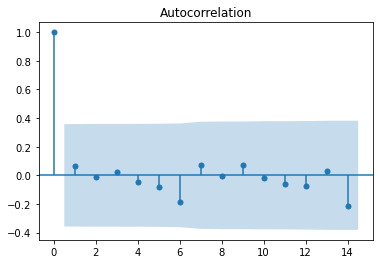

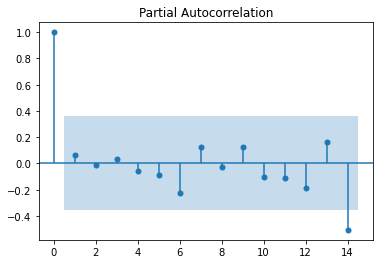

In [23]:
plot_forecast(f2,48)

Видно, что она склонна давать пессимистический прогноз, занижая тренд.

Сравним модели на предсказательную силу

In [24]:
#MSE for period T
MSE = lambda model,T=48: sum((np.exp(model.forecast(T))-data_part1.WAG_C_M[:T])**2)/T

In [25]:
MSE(fitted,48)<MSE(f2,48)

False

In [26]:
MSE(fitted,12)<MSE(f2,12)

False

In [27]:
fitted.aic<f2.aic

False

На отложенной выборке первая модель позволяет делать долгосрочный прогноз, информационный критерий так же меньше на первом варианте. Останавливаемся на ней

Обнаружив критерии проверки, давайте попробуем улучшить модель, использовав преобразование Бокса-Кокса, которое уже не будет иметь прозрачного смылса, как это было с логарифмом

In [28]:
from scipy.stats import boxcox

def invboxcox(data,a):
    return (a*data+1)**(1/a)

In [29]:
y_boxcox,alpha = boxcox(data.wages)

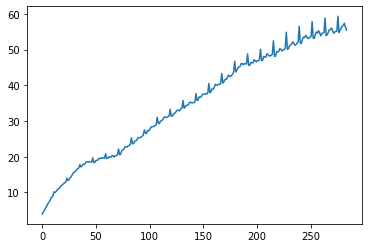

In [30]:
plt.plot(y_boxcox)

In [31]:
data['boxcox']=y_boxcox

pr_aDF(data.boxcox)

Augmented Dickey-Fuller test p-value for column boxcox: p=0.6968987634832653


In [32]:
pr_aDF(data.boxcox.diff().dropna())

Augmented Dickey-Fuller test p-value for column boxcox: p=0.01439615216494412


In [33]:
pr_aDF(data.boxcox.diff(12).diff(1).dropna())

Augmented Dickey-Fuller test p-value for column boxcox: p=5.203603715821631e-08


In [34]:
y = data.boxcox.diff(12).diff(1).dropna()[-72:]

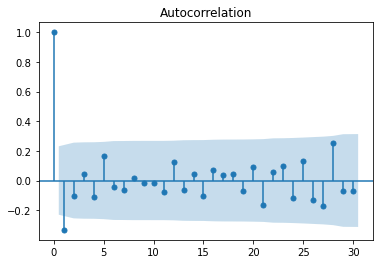

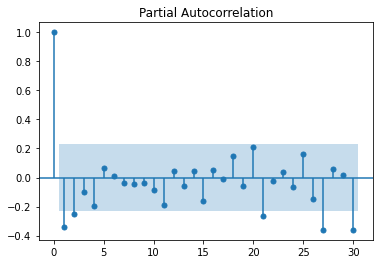

In [35]:
plot_acf(y,lags=30)
plot_pacf(y,lags=30)
plt.show()

In [36]:
d,D=1,1;
p=30;P=0;
q=1;Q=0

In [ ]:
f3 = ARIMA(data.boxcox.dropna(),order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()

In [ ]:
plt.plot(data.wages[-60:])
plt.plot(invboxcox(f3.forecast(23),alpha))
plt.plot(data_part1.WAG_C_M)

In [ ]:
f3.summary()

In [ ]:
f3.aic<fitted.aic

In [ ]:
sum((invboxcox(f3.forecast(24),alpha)-data_part1.WAG_C_M[:24])**2)/24<MSE(fitted,24)

Преобразованные таким образом данные не дают каких-либо значимых улучшений, скорее наоборот, уступают модели, в которой просто больше параметров